In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Hurricane Data Conversion

## Introduction
Purpose of this notebook is to outline a method of converting hurricane data is a summary format for larger scale analysis, specifically time series analysis of overall storm behaviors. This is not the final product, instead it is an idea to be built upon and used by others.

## Importing Libraries
We start by importing the necessary Python libraries and modules to work with our data.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import contextily as ctx

# Inital Data Format
Each row of the original data represents a moment of a storm, each moment has an ID and to identify which storm it is from as well as time info to identify when in the storm the moment is from.

In [12]:
pacific = pd.read_csv('/kaggle/input/hurricane-database/pacific.csv')
pacific.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,EP011949,UNNAMED,19490611,0,,TS,20.2N,106.3W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,EP011949,UNNAMED,19490611,600,,TS,20.2N,106.4W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,EP011949,UNNAMED,19490611,1200,,TS,20.2N,106.7W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,EP011949,UNNAMED,19490611,1800,,TS,20.3N,107.7W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,EP011949,UNNAMED,19490612,0,,TS,20.4N,108.6W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


# clean_up()
Intial cleaning of the data for conversion
- **Replace** -999 with NaN 
- **Map** function to strip coordinate columns NEWS
- fixing the date column
- Converting to a geopandas dataframe


In [13]:
def clean_up(pacific):
    #alarming amount of values -999, which means missing values, for earlier years 
    pacific = pacific.replace(-999, np.nan)


    #ValueError: could not convert string to float: '106.3W'
    #clean coordinate columns for conversion 
    pacific['Latitude'] = pacific['Latitude'].map(lambda x: x.rstrip('NEWS'))
    pacific['Longitude'] = pacific['Longitude'].map(lambda x: x.rstrip('NEWS'))

    #fixing the date column here 

    pacific['Date'] = pacific['Date'].astype(str)

    # Convert the string values to datetime objects
    pacific['Date'] = pd.to_datetime(pacific['Date'], format='%Y%m%d')

    # Create the GeoDataFrame with geometry
    pacific = gpd.GeoDataFrame(
        pacific,
        geometry=gpd.points_from_xy(pacific.Longitude, pacific.Latitude),
        crs="EPSG:4326"
    )
    
    return pacific




# convert_to_paths()
Conversion of the data into summarized version, where each row represents a storm instead of a moment of a storm. The geometry column now repsents a linestring of a storm path that can be better vizualized compared to moments with point geometries.
- ID = storm ID
- start_date = start date 
- end_date = end date 
- duration = duration 
- $$_per = percentage of this classification in the storm 
- min_press = minimum pressure
- avg_max_wind = average max wind measure for all moments 
- max_wind = maximum wind measure 
- line_geometry = geometry representing the storm path


In [8]:
def convert_to_paths(pacific):
    
    pacific = clean_up(pacific)
    
    # Assuming you have a DataFrame hurri_df and 'ID' column
    ids = pacific['ID'].unique()

    # Create an empty DataFrame with columns
    result_columns = ['ID', 'start_date','end_date','duration',
        'TS_per',
        'HU_per',
        'TD_per',
        'EX_per',
        'LO_per',
        'ET_per',
        'DB_per',
        'SD_per',
        'SS_per',
        'PT_per',
        'ST_per',
        'min_press','avg_max_wind','max_wind', 'line_geometry'] 


    result_df = pd.DataFrame(columns=result_columns)

    for id in ids: 

        #lines portion 
        hurri_subset = pacific[pacific['ID'] == id]
        line_points = [point for point in hurri_subset['geometry']]
      

        if len(line_points) > 1:
            line = LineString(line_points)

        #start date

            start_date = hurri_subset['Date'].iloc[0]

        #end date
            end_date = hurri_subset['Date'].iloc[-1]

        #duration 

            duration = end_date - start_date


        #average max wind speed 

            avg_max_wind = hurri_subset['Maximum Wind'].mean()

        #max wind speed

            max_wind = hurri_subset['Maximum Wind'].max()

        #min pressure
            min_press = hurri_subset['Minimum Pressure'].min()


        # Calculate the percentage of each value in the 'Status' column
            total_rows = len(pacific)
            value_counts = pacific['Status'].value_counts()

        # Calculate and store the percentage for each value in separate variables
            for value, count in value_counts.items():
                percentage = (count / total_rows) * 100
                variable_name = f'{value.lstrip().rstrip()}_per'
                globals()[variable_name] = percentage




        #append a new row to the result DataFrame
            result_df.loc[len(result_df.index)] = [id, start_date, end_date, duration, TS_per, HU_per,TD_per,EX_per,LO_per,ET_per,DB_per,SD_per,SS_per,PT_per,ST_per,min_press, avg_max_wind, max_wind, line]


    # Convert the result DataFrame to a GeoDataFrame
    result_gdf = gpd.GeoDataFrame(result_df, geometry='line_geometry') 
    result_gdf.crs = pacific.crs
    
    return result_gdf

# Inital Format Plotted

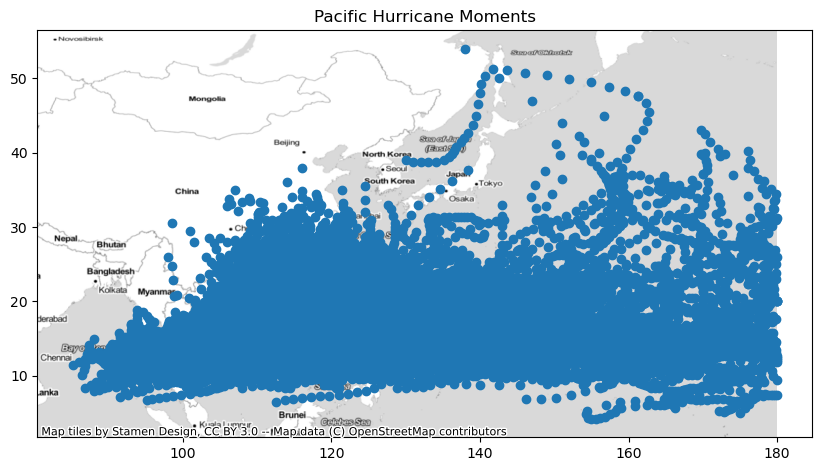

In [15]:
new = clean_up(pacific)
# Plot the GeoDataFrame with a background map
ax = new.plot(figsize=(10, 8))
ctx.add_basemap(ax, crs=new.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
ax.set_title("Pacific Hurricane Moments")

# Show the plot
plt.show()

In [ ]:
result = convert_to_paths(pacific)

In [17]:
result

,ID,start_date,end_date,duration,TS_per,HU_per,TD_per,EX_per,LO_per,ET_per,DB_per,SD_per,SS_per,PT_per,ST_per,min_press,avg_max_wind,max_wind,line_geometry
0,EP011949,1949-06-11,1949-06-12,1 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,NaN,45.000000,45,"LINESTRING (106.30000 20.20000, 106.40000 20.2..."
1,EP021949,1949-06-17,1949-06-23,6 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,NaN,45.000000,45,"LINESTRING (107.00000 14.10000, 107.70000 14.6..."
2,EP031949,1949-09-03,1949-09-09,6 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,NaN,45.000000,45,"LINESTRING (106.30000 17.30000, 106.60000 17.6..."
3,EP041949,1949-09-09,1949-09-11,2 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,NaN,75.000000,75,"LINESTRING (108.60000 19.30000, 109.40000 20.2..."
4,EP051949,1949-09-17,1949-09-19,2 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,NaN,45.000000,45,"LINESTRING (101.30000 15.40000, 102.80000 15.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,EP182015,2015-10-09,2015-10-15,6 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,993.0,39.259259,60,"LINESTRING (130.20000 10.60000, 131.60000 10.8..."
1045,EP192015,2015-10-15,2015-10-28,13 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,938.0,74.454545,130,"LINESTRING (117.00000 10.20000, 118.20000 10.3..."
1046,EP202015,2015-10-20,2015-10-24,4 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,872.0,83.947368,185,"LINESTRING (94.00000 13.40000, 94.20000 13.300..."
1047,EP212015,2015-11-18,2015-11-26,8 days,38.550714,0.003826,26.648047,0.420859,6.993917,0.581551,0.830241,0.015304,0.026782,0.022956,0.022956,1002.0,28.484848,35,"LINESTRING (107.10000 12.90000, 106.90000 12.9..."


# Hurripy Format Plotted

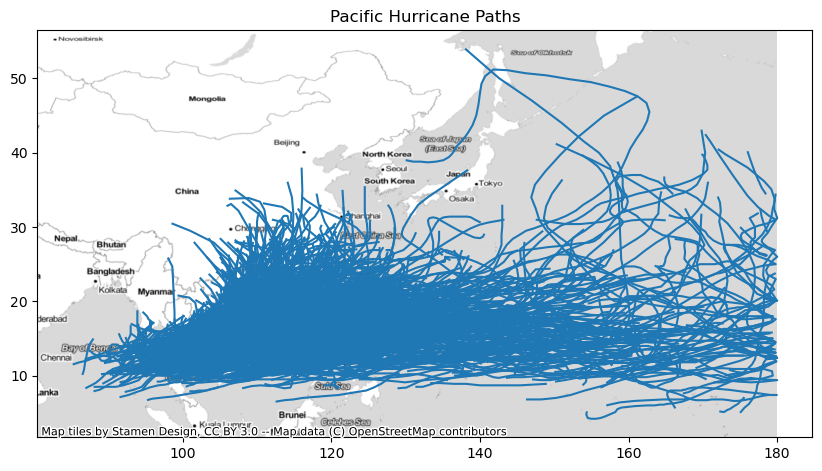

In [18]:

# Plot the GeoDataFrame with a background map
ax = result.plot(figsize=(10, 8))
ctx.add_basemap(ax, crs=result.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
ax.set_title("Pacific Hurricane Paths")

# Show the plot
plt.show()
